In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
tf.__version__

'2.16.1'

In [3]:
warnings.filterwarnings('ignore', category=UserWarning, message=r'.*PyDataset.*')

## Load Images And Labels

In [4]:
import os
from PIL import Image, UnidentifiedImageError

# Root directory of the images
root_dir = 'trafficsigns_dataset'  # Replace with the actual path

# Nested dictionary to store images categorized by two levels of labels
images_by_label = {}

# Function to traverse the dataset and load images and their labels
def load_images_and_labels(root_dir):
    # Iterate through each subdirectory in the root directory (first level)
    for sub_dir in os.listdir(root_dir):
        sub_dir_path = os.path.join(root_dir, sub_dir)
        
        # Check if the subdirectory is indeed a directory
        if os.path.isdir(sub_dir_path):
            # Initialize the first level label key
            images_by_label[sub_dir] = {}
            
            # Iterate again through the folders within the subdirectory (second level, specific labels)
            for label_dir in os.listdir(sub_dir_path):
                label_dir_path = os.path.join(sub_dir_path, label_dir)
                
                # Check if the second level is also a directory
                if os.path.isdir(label_dir_path):
                    # Initialize the second level label key
                    images_by_label[sub_dir][label_dir] = []
                    
                    # Iterate through all image files in the second level directory
                    for image_filename in os.listdir(label_dir_path):
                        # Ignore .DS_Store files
                        if image_filename == '.DS_Store':
                            continue
                        image_path = os.path.join(label_dir_path, image_filename)
                        try:
                            images_by_label[sub_dir][label_dir].append(image_path)
                        except UnidentifiedImageError:
                            # Print error message if the image cannot be identified
                            print(f"Cannot identify image file '{image_path}'")


# Load images and labels
load_images_and_labels(root_dir)

# Print the number of images for each category
for sub_dir, labels in images_by_label.items():
    for label, images in labels.items():
        print(f"{sub_dir}/{label}: {len(images)} images")
        
# Print the number of types for each shape
for shape, images in images_by_label.items():
    print(f"{shape}: {len(images)} type")
        
# Store unique shape names in label_names
label_names = list(images_by_label.keys())

# Now label_names contains all unique labels (shapes), sorted alphabetically
print(label_names)

diamond/rightofway: 282 images
hex/stop: 43 images
round/bicycle: 285 images
round/limitedtraffic: 125 images
round/noentry: 375 images
round/noparking: 242 images
round/roundabout: 98 images
round/speed: 316 images
round/trafficdirective: 195 images
round/traveldirection: 124 images
square/continue: 199 images
square/crossing: 95 images
square/laneend: 118 images
square/parking: 276 images
triangle/giveway: 231 images
triangle/warning: 695 images
diamond: 1 type
hex: 1 type
round: 8 type
square: 4 type
triangle: 2 type
['diamond', 'hex', 'round', 'square', 'triangle']


28no Unusual

In [5]:
def get_image_sizes(root_dir):
    sizes = []
    # Traverse through the directory structure in root_dir
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            # Check if the file is a PNG or JPG
            if file.lower().endswith('.png') or file.lower().endswith('.jpg'):
                try:
                    # Open the image file and append its size (width, height)
                    with Image.open(os.path.join(subdir, file)) as img:
                        sizes.append(img.size)
                except (IOError, UnidentifiedImageError):
                    # Continue to the next file if an error occurs
                    continue
    return sizes

# Call the function to get the sizes of all images in the directory
image_sizes = get_image_sizes(root_dir)

# Convert list of sizes to a NumPy array for statistical calculation
sizes_np = np.array(image_sizes)
min_size = sizes_np.min(axis=0)
max_size = sizes_np.max(axis=0)
mean_size = sizes_np.mean(axis=0)
std_dev_size = sizes_np.std(axis=0)
median_size = np.median(sizes_np, axis=0)

# Output the minimum, maximum, mean, standard deviation, and median sizes of the images
min_size, max_size, mean_size, std_dev_size, median_size


(array([28, 28]),
 array([28, 28]),
 array([28., 28.]),
 array([0., 0.]),
 array([28., 28.]))

In [6]:
train_data = {}
test_data = {}
validation_data = {}

for first_level, second_level_dict in images_by_label.items():
    print(first_level)
    train_data[first_level] = {}
    validation_data[first_level] = {}
    test_data[first_level] = {}
    
    for label, image_paths in second_level_dict.items():
        temp_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(temp_images, test_size=0.2, random_state=42)
        
        # Save split data
        train_data[first_level][label] = train_images
        test_data[first_level][label] = test_images
        validation_data[first_level][label] = val_images


diamond
hex
round
square
triangle


## Genarate Datasets

In [7]:
train_data = {}
test_data = {}
validation_data = {}

for first_level, second_level_dict in images_by_label.items():
    train_data[first_level] = {}
    validation_data[first_level] = {}
    test_data[first_level] = {}
    
    for label, image_paths in second_level_dict.items():
        temp_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(temp_images, test_size=0.2, random_state=42)
        
        # Save split data
        train_data[first_level][label] = train_images
        test_data[first_level][label] = test_images
        validation_data[first_level][label] = val_images


In [8]:
def create_dataframe_for_16_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                # Extract the shape from the label
                shape = first_level
                rows.append({'ImagePath': path, 'Label': shape})
    return pd.DataFrame(rows)

def create_dataframe_for_5_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                # Extract the shape from the label
                shape = first_level.split('_')[0]
                rows.append({'ImagePath': path, 'Label': shape})
    return pd.DataFrame(rows)

train_df = create_dataframe_for_5_class(train_data)
test_df = create_dataframe_for_5_class(test_data)
validation_df = create_dataframe_for_5_class(validation_data)


In [9]:
batch_size = 64

In [10]:
validation_df

,ImagePath,Label
0,trafficsigns_dataset\diamond\rightofway\00042_...,diamond
1,trafficsigns_dataset\diamond\rightofway\00045_...,diamond
2,trafficsigns_dataset\diamond\rightofway\01511_...,diamond
3,trafficsigns_dataset\diamond\rightofway\00050_...,diamond
4,trafficsigns_dataset\diamond\rightofway\01883_...,diamond
...,...,...
591,trafficsigns_dataset\triangle\warning\01888_00...,triangle
592,trafficsigns_dataset\triangle\warning\00454_00...,triangle
593,trafficsigns_dataset\triangle\warning\01086_00...,triangle
594,trafficsigns_dataset\triangle\warning\00008_00...,triangle


In [11]:
# Count the number of unique labels and their counts
train_df['Label'].value_counts().sort_index()

Label
diamond      180
hex           27
round       1122
square       438
triangle     591
Name: count, dtype: int64

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize image data generators with rescaling
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Assuming train_df, validation_df, test_df, and batch_size are already defined
# Create a training data generator from a dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=True                # Shuffle the order of the images
)

# Create a validation data generator from a dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=False               # Do not shuffle the images
)

# Create a test data generator from a dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=False               # Do not shuffle the images
)


Found 2358 validated image filenames belonging to 5 classes.
Found 596 validated image filenames belonging to 5 classes.
Found 745 validated image filenames belonging to 5 classes.


## Transfer data to suit scikit-learn

In [13]:
import numpy as np

def get_data_from_generator(generator):
    batches = []
    labels = []
    # Iterate over the generator to collect data and labels
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # Ensure not to iterate infinitely
    return np.vstack(batches), np.vstack(labels)

# Get training, validation, and test data and labels
X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)


## Prepare function to draw Macro Average and F1 Score

In [14]:
class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.f1_scores = []
        
    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.val_data)
        val_pred = np.argmax(val_pred, axis=1)
        val_true = self.val_data.classes
        
        f1_scores_per_class = []
        for i in range(num_classes):
            f1 = tf.metrics.f1_score(val_true, val_pred, weights=tf.equal(val_true, i), name=f'f1_class_{i}')
            f1_scores_per_class.append(f1)
        
        macro_f1 = tf.metrics.mean(f1_scores_per_class)
        self.f1_scores.append(macro_f1[1])
        print(f"Epoch {epoch+1}: Macro Average F1 Score = {macro_f1[1]:.4f}")

## Decision Tree

In [15]:
# Assume the original shape of X_train and X_val is [number of samples, 28, 28, 1] - as extracted from an image generator

# Reshape X_train and X_val into two-dimensional arrays, one row per image
X_train = X_train.reshape(X_train.shape[0], -1)  # -1 calculates the necessary size based on the remaining dimensions
X_val = X_val.reshape(X_val.shape[0], -1)

# If using get_data_from_generator function to extract data, make sure to adjust the function or data before reshaping
# For example, ensure data is correctly extracted and transformed from the generator
X_train, y_train = get_data_from_generator(train_generator)
X_train = X_train.reshape(X_train.shape[0], -1)

X_val, y_val = get_data_from_generator(val_generator)
X_val = X_val.reshape(X_val.shape[0], -1)

# Train the decision tree model
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = tree_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.8305369127516778


## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model using the validation set
y_pred_val = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.889261744966443


## SVM

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming y_train and y_val are one-hot encoded, with shape (number of samples, number of categories)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Initialize and apply normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model on the validation set
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.9546979865771812


## MLP Baseline Model for Multi-class Task


### Adjust the Model Compilation

In [18]:
num_classes = 5
input_shape = (28, 28)
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
baseline_categorical.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'), #Get F1 Score by tensorflow API
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])

### Training the Model

In [20]:
epochs = 50
macro_f1_callback = MacroF1Callback(val_generator)
history_baseline_categorical = baseline_categorical.fit(
    train_generator, 
    validation_data=val_generator,
    epochs=epochs,

)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5642 - f1_score_macro: 0.3399 - f1_score_micro: 0.5642 - f1_score_weighted: 0.5387 - loss: 1.1900 - val_accuracy: 0.8238 - val_f1_score_macro: 0.5883 - val_f1_score_micro: 0.8238 - val_f1_score_weighted: 0.8052 - val_loss: 0.6026
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8592 - f1_score_macro: 0.6531 - f1_score_micro: 0.8592 - f1_score_weighted: 0.8487 - loss: 0.5595 - val_accuracy: 0.8490 - val_f1_score_macro: 0.6652 - val_f1_score_micro: 0.8490 - val_f1_score_weighted: 0.8467 - val_loss: 0.5019
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8836 - f1_score_macro: 0.6994 - f1_score_micro: 0.8836 - f1_score_weighted: 0.8781 - loss: 0.4086 - val_accuracy: 0.9044 - val_f1_score_macro: 0.7545 - val_f1_score_micro: 0.9044 - val_f1_score_weighted: 0.8991 - val_loss: 0.3662
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9269 - f1_score_macro: 0.8116 - f1_score_micro: 0.

Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9977 - f1_score_macro: 0.9974 - f1_score_micro: 0.9977 - f1_score_weighted: 0.9977 - loss: 0.0221 - val_accuracy: 0.9698 - val_f1_score_macro: 0.9399 - val_f1_score_micro: 0.9698 - val_f1_score_weighted: 0.9695 - val_loss: 0.1004
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9991 - f1_score_macro: 0.9832 - f1_score_micro: 0.9991 - f1_score_weighted: 0.9991 - loss: 0.0195 - val_accuracy: 0.9698 - val_f1_score_macro: 0.9421 - val_f1_score_micro: 0.9698 - val_f1_score_weighted: 0.9696 - val_loss: 0.1155
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9998 - f1_score_macro: 0.9998 - f1_score_micro: 0.9998 - f1_score_weighted: 0.9998 - loss: 0.0163 - val_accuracy: 0.9581 - val_f1_score_macro: 0.9202 - val_f1_score_micro: 0.9581 - val_f1_score_weighted: 0.9580 - val_loss: 0.1225
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9996 - f1_score_macro: 0.9940 - f1_score_micro

### Plotting and Evaluating

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9555 - f1_score_macro: 0.7034 - f1_score_micro: 0.9555 - f1_score_weighted: 0.9605 - loss: 0.1458
  Accuracy Type  Accuracy
0      Training  0.999576
1    Validation  0.971476
2       Testing  0.961074


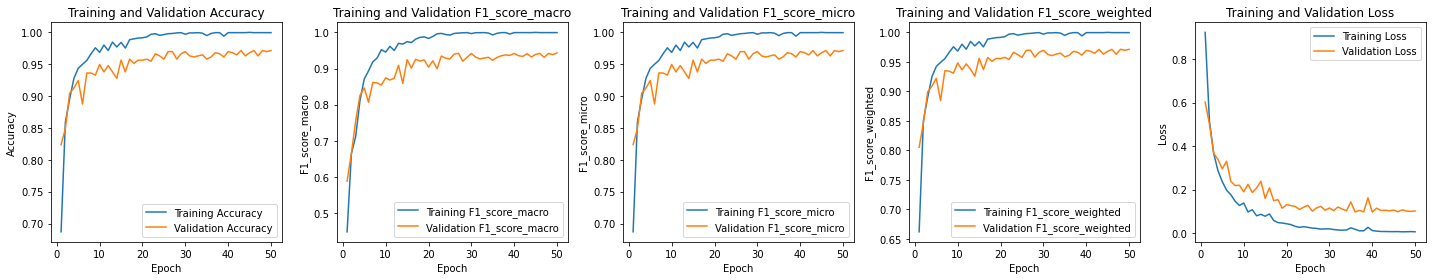

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have test_generator or similar test data
test_loss, test_accuracy, _, _, _ = baseline_categorical.evaluate(test_generator)

# Get training and validation accuracy from the history object
train_accuracy = history_baseline_categorical.history['accuracy'][-1]
val_accuracy = history_baseline_categorical.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)

def plot_training_history(history):
    """
    Plot training and validation metrics based on the History object from a Keras model.

    Parameters:
    - history: History object returned from the fit method.
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)  # Assuming there's at least the 'accuracy' metric
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # Retrieve all non-validation metrics
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # Dynamically adjust the number of subplots based on the number of metrics

    for idx, metric in enumerate(metrics):
        # Plot the training and validation curve for each metric in each subplot
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# Assuming history_baseline_categorical is the training history object of your MLP model
# Call the function to plot
plot_training_history(history_baseline_categorical)


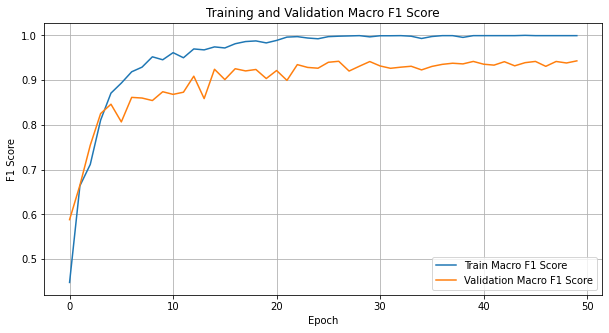

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_baseline_categorical.history['f1_score_macro'], label='Train Macro F1 Score')
plt.plot(history_baseline_categorical.history['val_f1_score_macro'], label='Validation Macro F1 Score')
plt.title('Training and Validation Macro F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
              precision    recall  f1-score   support

     diamond       0.94      0.98      0.96        45
         hex       1.00      0.71      0.83         7
       round       0.98      0.97      0.98       284
      square       0.99      0.98      0.99       111
    triangle       0.95      0.97      0.96       149

    accuracy                           0.97       596
   macro avg       0.97      0.92      0.94       596
weighted avg       0.97      0.97      0.97       596



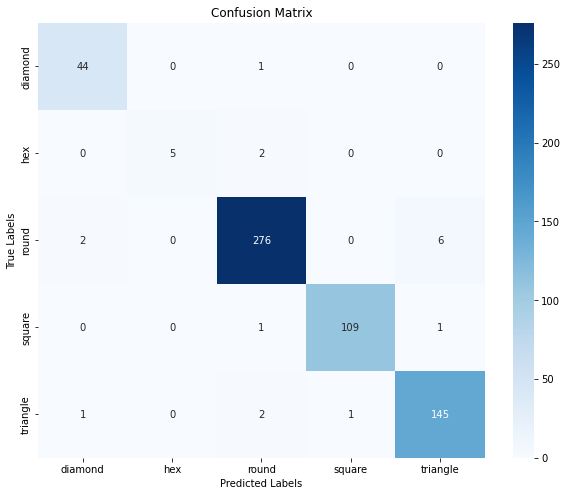

In [23]:
y_pred_val_prob = baseline_categorical.predict(val_generator)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(val_generator.classes, y_pred_val, target_names=label_names)
print(report)

cm = confusion_matrix(val_generator.classes, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## Modify images to make classification more difficult

In [24]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotation range (degrees), adjustable range, e.g., 20-40
    width_shift_range=0.1,  # Horizontal shift range
    height_shift_range=0.1,  # Vertical shift range
    shear_range=0.1,  # Shearing range
    zoom_range=0.1,  # Zoom range
    horizontal_flip=True,  # Horizontal flip
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False
)


Found 2358 validated image filenames belonging to 5 classes.
Found 596 validated image filenames belonging to 5 classes.
Found 745 validated image filenames belonging to 5 classes.


## SVM Model with modified dataset

In [25]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def get_data_from_generator(generator):
    batches = []
    labels = []
    # Iterate over the generator to collect data and labels
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # Ensure there is no infinite iteration
    return np.vstack(batches), np.vstack(labels)

X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)

# Reshape the data to fit the input requirements of StandardScaler
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Assuming y_train and y_val are one-hot encoded, with shape (number of samples, number of classes)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Initialize and apply standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model on the validation set
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))

report = classification_report(y_val, y_pred_val, target_names=label_names, zero_division=1, output_dict=True)
print(classification_report(y_val, y_pred_val, target_names=label_names, zero_division=1))


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.8036912751677853
              precision    recall  f1-score   support

     diamond       0.96      0.60      0.74        45
         hex       1.00      0.00      0.00         7
       round       0.77      0.95      0.85       284
      square       0.82      0.58      0.68       111
    triangle       0.86      0.79      0.82       149

    accuracy                           0.80       596
   macro avg       0.88      0.58      0.62       596
weighted avg       0.82      0.80      0.79       596



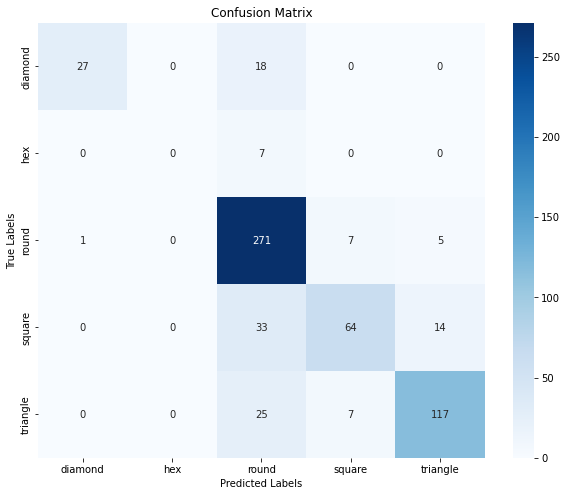

In [26]:
cm = confusion_matrix(val_generator.classes, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## MLP Model with modified dataset

### Adjust the Model Compilation

In [27]:
num_classes = 5
input_shape = (28, 28)
baseline_categorical_new = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [28]:
baseline_categorical_new.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])

### Training the Model

In [29]:
epochs = 50
history_baseline_categorical_new = baseline_categorical_new.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.4755 - f1_score_macro: 0.1843 - f1_score_micro: 0.4755 - f1_score_weighted: 0.3680 - loss: 0.4676 - val_accuracy: 0.6174 - val_f1_score_macro: 0.3206 - val_f1_score_micro: 0.6174 - val_f1_score_weighted: 0.5491 - val_loss: 0.3718
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.5666 - f1_score_macro: 0.2626 - f1_score_micro: 0.5666 - f1_score_weighted: 0.4778 - loss: 0.3870 - val_accuracy: 0.6409 - val_f1_score_macro: 0.3357 - val_f1_score_micro: 0.6409 - val_f1_score_weighted: 0.5662 - val_loss: 0.3367
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5746 - f1_score_macro: 0.3018 - f1_score_micro: 0.5746 - f1_score_weighted: 0.5080 - loss: 0.3698 - val_accuracy: 0.7047 - val_f1_score_macro: 0.4797 - val_f1_score_micro: 0.7047 - val_f1_score_weighted: 0.6688 - val_loss: 0.3135
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.6132 - f1_score_macro: 0.3625 - f1_score_micro: 

Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7404 - f1_score_macro: 0.5430 - f1_score_micro: 0.7404 - f1_score_weighted: 0.7280 - loss: 0.2580 - val_accuracy: 0.8221 - val_f1_score_macro: 0.6301 - val_f1_score_micro: 0.8221 - val_f1_score_weighted: 0.8189 - val_loss: 0.2042
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7589 - f1_score_macro: 0.5565 - f1_score_micro: 0.7589 - f1_score_weighted: 0.7476 - loss: 0.2468 - val_accuracy: 0.8456 - val_f1_score_macro: 0.6455 - val_f1_score_micro: 0.8456 - val_f1_score_weighted: 0.8426 - val_loss: 0.1937
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7611 - f1_score_macro: 0.5601 - f1_score_micro: 0.7611 - f1_score_weighted: 0.7492 - loss: 0.2479 - val_accuracy: 0.8272 - val_f1_score_macro: 0.6327 - val_f1_score_micro: 0.8272 - val_f1_score_weighted: 0.8189 - val_loss: 0.1985
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7400 - f1_score_macro: 0.5253 - f1_score_micro

### Plotting and Evaluating

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8642 - f1_score_macro: 0.4872 - f1_score_micro: 0.8642 - f1_score_weighted: 0.8660 - loss: 0.1672
  Accuracy Type  Accuracy
0      Training  0.816370
1    Validation  0.892617
2       Testing  0.895302


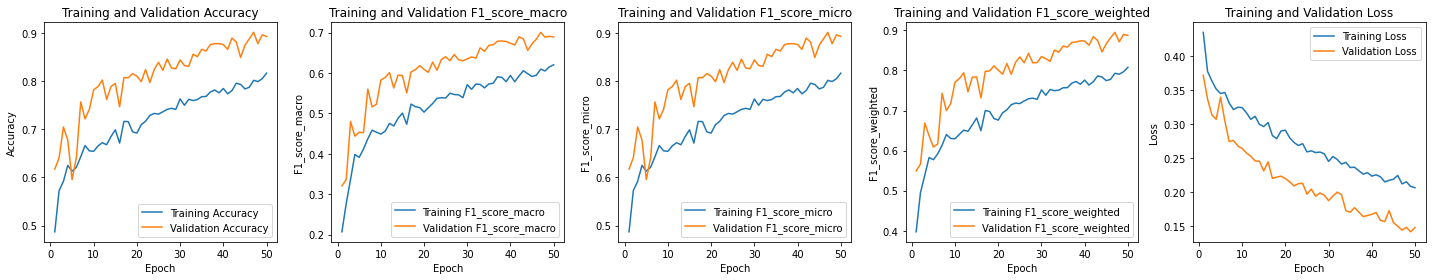

In [30]:
# Evaluate the model on the test data
test_loss, test_accuracy, _, _, _ = baseline_categorical_new.evaluate(test_generator)

# Get training and validation accuracy from the history object
train_accuracy = history_baseline_categorical_new.history['accuracy'][-1]
val_accuracy = history_baseline_categorical_new.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)

def plot_training_history(history):
    """
    Plot training and validation metrics based on the History object from a Keras model.

    Parameters:
    - history: History object returned from the fit method.
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1) 
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # Retrieve all non-validation metrics
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # Dynamically adjust the number of subplots based on the number of metrics

    for idx, metric in enumerate(metrics):
        # Plot the training and validation curve for each metric in each subplot
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# Assuming history_baseline_categorical_new is the training history object of your MLP model
# Call the function to plot
plot_training_history(history_baseline_categorical_new)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              precision    recall  f1-score   support

     diamond       0.71      0.71      0.71        45
         hex       0.00      0.00      0.00         7
       round       0.91      0.92      0.91       284
      square       0.90      0.89      0.90       111
    triangle       0.91      0.93      0.92       149

    accuracy                           0.89       596
   macro avg       0.69      0.69      0.69       596
weighted avg       0.88      0.89      0.89       596



C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


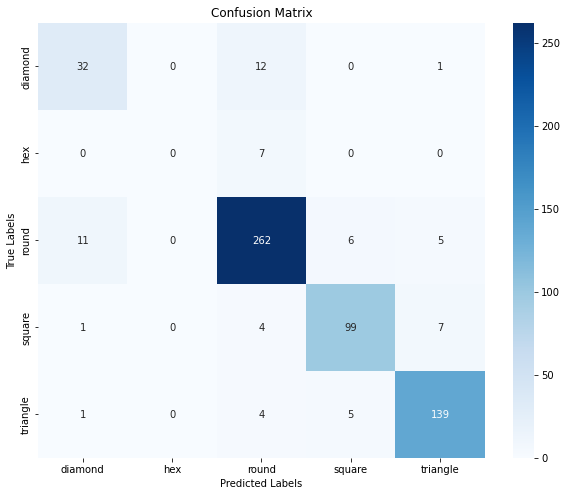

In [31]:
y_pred_val_prob = baseline_categorical_new.predict(val_generator)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(val_generator.classes, y_pred_val, target_names=label_names)
print(report)

cm = confusion_matrix(val_generator.classes, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## CNN Model for Multi Class

### Create CNN

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 5

cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  
    layers.Conv2D(32, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  
    layers.Conv2D(64, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  
    layers.Conv2D(128, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  
    layers.Flatten(),  
    layers.Dense(512, activation='relu'),  
    layers.Dense(num_classes, activation='softmax')  
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])


### Per-Class Macro F1 Score Callback

In [33]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class PerClassF1Score(Callback):
    def __init__(self, validation_generator, num_classes):
        super().__init__()
        self.validation_generator = validation_generator
        self.num_classes = num_classes
        self.f1_scores_per_class = []

    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(self.validation_generator)
        val_classes = np.argmax(val_preds, axis=1)
        true_classes = self.validation_generator.classes
        # Initialize confusion matrix components
        TP = np.zeros(self.num_classes)
        FP = np.zeros(self.num_classes)
        FN = np.zeros(self.num_classes)
        
        for true, pred in zip(true_classes, val_classes):
            if true == pred:
                TP[true] += 1
            else:
                FP[pred] += 1
                FN[true] += 1

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        self.f1_scores_per_class.append(f1_score)  # Save per-class F1 scores for this epoch


In [34]:
validation_data = val_generator  
per_class_f1_score_callback = PerClassF1Score(validation_data, num_classes)

epochs = 50
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[per_class_f1_score_callback],
    verbose=1
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4163 - f1_score_macro: 0.1520 - f1_score_micro: 0.4163 - f1_score_weighted: 0.3091 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.4193 - f1_score_macro: 0.1527 - f1_score_micro: 0.4193 - f1_score_weighted: 0.3110 - loss: 1.3730 - val_accuracy: 0.5268 - val_f1_score_macro: 0.1993 - val_f1_score_micro: 0.5268 - val_f1_score_weighted: 0.4017 - val_loss: 1.1943
Epoch 2/50


C:\Users\HP\AppData\Local\Temp/ipykernel_27388/367617216.py:27: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5419 - f1_score_macro: 0.2466 - f1_score_micro: 0.5419 - f1_score_weighted: 0.4507 - loss: 1
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5441 - f1_score_macro: 0.2490 - f1_score_micro: 0.5441 - f1_score_weighted: 0.4539 - loss: 1.1543 - val_accuracy: 0.6678 - val_f1_score_macro: 0.3766 - val_f1_score_micro: 0.6678 - val_f1_score_weighted: 0.6131 - val_loss: 0.9328
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6590 - f1_score_macro: 0.3837 - f1_score_micro: 0.6590 - f1_score_weighted: 0.6122 - loss: 0
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6610 - f1_score_macro: 0.3857 - f1_score_micro: 0.6610 - f1_score_weighted: 0.6146 - loss: 0.9212 - val_accuracy: 0.7785 - val_f1_score_macro: 0.4782 - val_f1_score_micro: 0.7785 - val_f1_score_weighted: 0.7399 - val_loss: 0.6441
Epoch 4/50


C:\Users\HP\AppData\Local\Temp/ipykernel_27388/367617216.py:29: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7588 - f1_score_macro: 0.5133 - f1_score_micro: 0.7588 - f1_score_weighted: 0.7336 - loss: 0
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.7589 - f1_score_macro: 0.5139 - f1_score_micro: 0.7589 - f1_score_weighted: 0.7338 - loss: 0.7030 - val_accuracy: 0.8138 - val_f1_score_macro: 0.6271 - val_f1_score_micro: 0.8138 - val_f1_score_weighted: 0.8103 - val_loss: 0.5715
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step  - accuracy: 0.7875 - f1_score_macro: 0.5789 - f1_score_micro: 0.7875 - f1_score_weighted: 0.7764 - loss:
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7884 - f1_score_macro: 0.5805 - f1_score_micro: 0.7884 - f1_score_weighted: 0.7775 - loss: 0.5807 - val_accuracy: 0.8758 - val_f1_score_macro: 0.6786 - val_f1_score_micro: 0.8758 - val_f1_score_weighted: 0.8680 - val_loss: 0.3814
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8250 - f1_score_macro: 0.6288 - f1_score_micro: 0.8250 - f1_s

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9515 - f1_score_macro: 0.8828 - f1_score_micro: 0.9515 - f1_score_weighted: 0.9499 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9517 - f1_score_macro: 0.8835 - f1_score_micro: 0.9517 - f1_score_weighted: 0.9501 - loss: 0.1567 - val_accuracy: 0.9765 - val_f1_score_macro: 0.9496 - val_f1_score_micro: 0.9765 - val_f1_score_weighted: 0.9762 - val_loss: 0.0646
Epoch 21/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9540 - f1_score_macro: 0.8784 - f1_score_micro: 0.9540 - f1_score_weighted: 0.9526 - loss:
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9538 - f1_score_macro: 0.8788 - f1_score_micro: 0.9538 - f1_score_weighted: 0.9525 - loss: 0.1529 - val_accuracy: 0.9849 - val_f1_score_macro: 0.9568 - val_f1_score_micro: 0.9849 - val_f1_score_weighted: 0.9846 - val_loss: 0.0598
Epoch 22/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9563 - f1_score_macro: 0.9134 - f1_score_micro: 0.9563 - f1_s

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9694 - f1_score_macro: 0.9406 - f1_score_micro: 0.9694 - f1_score_weighted: 0.9693 - loss: 0
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9696 - f1_score_macro: 0.9408 - f1_score_micro: 0.9696 - f1_score_weighted: 0.9695 - loss: 0.0912 - val_accuracy: 0.9866 - val_f1_score_macro: 0.9852 - val_f1_score_micro: 0.9866 - val_f1_score_weighted: 0.9865 - val_loss: 0.0425
Epoch 37/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9785 - f1_score_macro: 0.9514 - f1_score_micro: 0.9785 - f1_score_weighted: 0.9784 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9781 - f1_score_macro: 0.9515 - f1_score_micro: 0.9781 - f1_score_weighted: 0.9780 - loss: 0.0660 - val_accuracy: 0.9933 - val_f1_score_macro: 0.9949 - val_f1_score_micro: 0.9933 - val_f1_score_weighted: 0.9933 - val_loss: 0.0365
Epoch 38/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9800 - f1_score_macro: 0.9740 - f1_score_micro: 0.9800 - f1_

### Plotting and Evaluating

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9856 - f1_score_macro: 0.7594 - f1_score_micro: 0.9856 - f1_score_weighted: 0.9873 - loss: 0.0546
  Accuracy Type  Accuracy
0      Training  1.000000
1    Validation  0.994966
2       Testing  0.989262


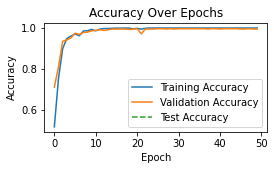

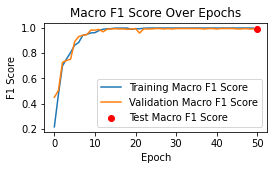

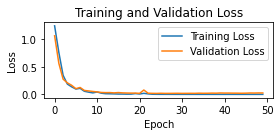

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Evaluate on the test set
test_loss, test_accuracy, test_f1_macro, _, _ = cnn_model.evaluate(test_generator)

# Gather accuracy data
train_accuracy = history_cnn.history['accuracy'][-1]
val_accuracy = history_cnn.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)

# Plot the training, validation, and testing accuracy
plt.figure(figsize=(4, 2))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.plot([None]*(epochs-1) + [test_accuracy], label='Test Accuracy', linestyle='--')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot macro F1 score
plt.figure(figsize=(4, 2))
plt.plot(history_cnn.history['f1_score_macro'], label='Training Macro F1 Score')
if 'val_f1_score_macro' in history_cnn.history:
    plt.plot(history_cnn.history['val_f1_score_macro'], label='Validation Macro F1 Score')
plt.scatter(epochs, test_f1_macro, color='red', label='Test Macro F1 Score')
plt.title('Macro F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(4, 2))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###  Extract and Plot Data

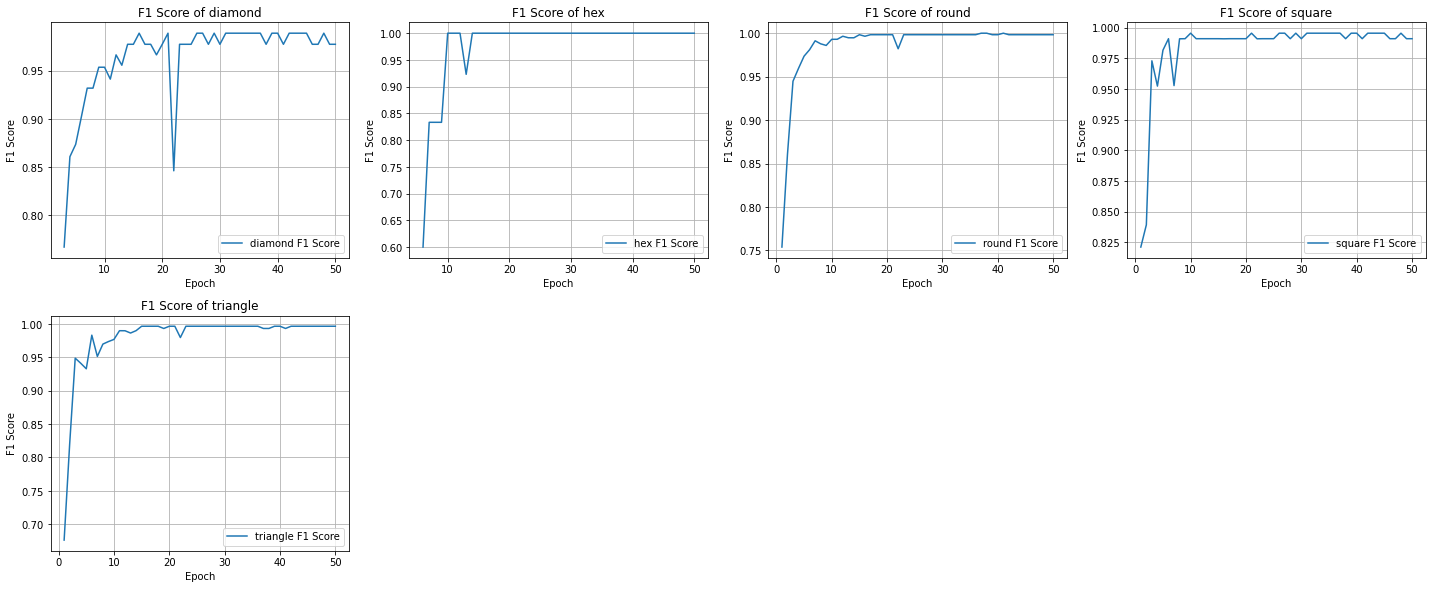

<Figure size 432x288 with 0 Axes>

In [32]:
def plot_per_class_f1_scores(callback, label_names):
    """
    Plot the per-class F1 scores over the epochs in a 4x4 grid, each subplot representing one class.

    Parameters:
    - callback: Instance of PerClassF1Score that has been used during model training.
    - label_names: List of label names corresponding to each class.
    """
    epochs = len(callback.f1_scores_per_class)
    num_classes = len(label_names)
    f1_scores = np.array(callback.f1_scores_per_class)  # Shape will be [epochs, num_classes]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
    axes = axes.flatten()

    for i in range(num_classes):
        ax = axes[i]
        ax.plot(range(1, epochs + 1), f1_scores[:, i], label=f'{label_names[i]} F1 Score')
        ax.set_title(f'F1 Score of {label_names[i]}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower right')
        ax.grid(True)
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

# Example of how to call this function
plot_per_class_f1_scores(per_class_f1_score_callback, label_names)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              precision    recall  f1-score   support

     diamond       1.00      0.96      0.98        45
         hex       1.00      1.00      1.00         7
       round       1.00      1.00      1.00       284
      square       0.99      0.99      0.99       111
    triangle       0.99      1.00      1.00       149

    accuracy                           0.99       596
   macro avg       1.00      0.99      0.99       596
weighted avg       0.99      0.99      0.99       596



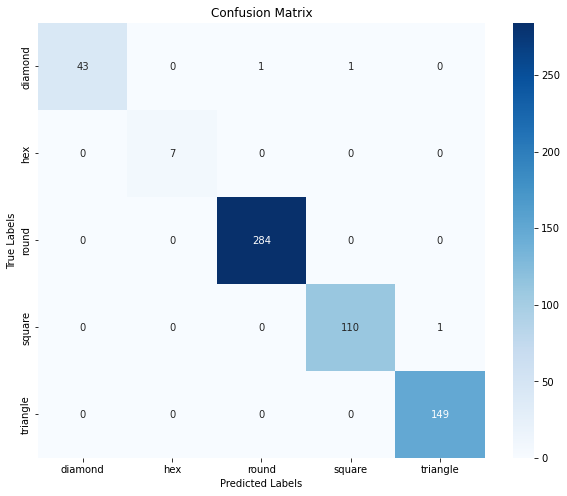

In [33]:
y_pred_val_prob = cnn_model.predict(val_generator)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(val_generator.classes, y_pred_val, target_names=label_names)
print(report)

cm = confusion_matrix(val_generator.classes, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



### Update CNN

In [39]:
from tensorflow.keras import models, layers

num_classes = 5  # Adjusting the number of classes according to shapes

updated_cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Input for grayscale images, 1 channel
    layers.Conv2D(32, (3, 3), padding='same'),  # First convolutional layer, 32 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(64, (3, 3), padding='same'),  # Second convolutional layer, 64 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(128, (3, 3), padding='same'),  # Third convolutional layer, 128 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Flatten(),  # Flatten the convolutional result
    layers.Dense(512),  # Fully connected layer
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.Dense(num_classes, activation='softmax')  # Output layer, using softmax activation
])

# Usage
validation_data = val_generator  
per_class_accuracy_callback = PerClassF1Score(validation_data, num_classes)

updated_cnn_model.compile(
    loss='categorical_crossentropy',  # Using categorical crossentropy loss
    optimizer=tf.keras.optimizers.Adam(),  # Adam optimizer
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'),
        tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
        tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
    ])


### Per class accuracy callback

In [40]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class PerClassF1Score(Callback):
    def __init__(self, validation_generator, num_classes):
        super().__init__()
        self.validation_generator = validation_generator
        self.num_classes = num_classes
        self.f1_scores_per_class = []

    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(self.validation_generator)
        val_classes = np.argmax(val_preds, axis=1)
        true_classes = self.validation_generator.classes
        # Initialize confusion matrix components
        TP = np.zeros(self.num_classes)
        FP = np.zeros(self.num_classes)
        FN = np.zeros(self.num_classes)
        
        for true, pred in zip(true_classes, val_classes):
            if true == pred:
                TP[true] += 1
            else:
                FP[pred] += 1
                FN[true] += 1

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        self.f1_scores_per_class.append(f1_score)  # Save per-class F1 scores for this epoch


### Training the Model

In [41]:
validation_data = val_generator  # Assume val_generator is already defined
per_class_accuracy_callback = PerClassF1Score(validation_data, num_classes)

epochs = 50
history_updated_cnn = updated_cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[per_class_accuracy_callback],
    verbose=1
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step  - accuracy: 0.6372 - f1_score_macro: 0.4912 - f1_score_micro: 0.6372 - f1_score_weighted: 0.6358 - loss:
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.6405 - f1_score_macro: 0.4948 - f1_score_micro: 0.6405 - f1_score_weighted: 0.6390 - loss: 0.9659 - val_accuracy: 0.4765 - val_f1_score_macro: 0.1291 - val_f1_score_micro: 0.4765 - val_f1_score_weighted: 0.3076 - val_loss: 1.3192
Epoch 2/50


C:\Users\HP\AppData\Local\Temp/ipykernel_27388/367617216.py:27: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8932 - f1_score_macro: 0.7524 - f1_score_micro: 0.8932 - f1_score_weighted: 0.8896 - loss: 0
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8935 - f1_score_macro: 0.7540 - f1_score_micro: 0.8935 - f1_score_weighted: 0.8900 - loss: 0.3231 - val_accuracy: 0.4765 - val_f1_score_macro: 0.1291 - val_f1_score_micro: 0.4765 - val_f1_score_weighted: 0.3076 - val_loss: 1.9044
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/stepp - accuracy: 0.9324 - f1_score_macro: 0.8846 - f1_score_micro: 0.9324 - f1_score_weighted: 0.9317 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9324 - f1_score_macro: 0.8845 - f1_score_micro: 0.9324 - f1_score_weighted: 0.9317 - loss: 0.1811 - val_accuracy: 0.4765 - val_f1_score_macro: 0.1291 - val_f1_score_micro: 0.4765 - val_f1_score_weighted: 0.3076 - val_loss: 2.1132
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/stepp - accuracy: 0.9413 - f1_score_macro: 0.8947 - f1_score_micro: 0.9413 - f1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/stepp - accuracy: 0.9915 - f1_score_macro: 0.9870 - f1_score_micro: 0.9915 - f1_score_weighted: 0.9915 - loss: 
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9915 - f1_score_macro: 0.9869 - f1_score_micro: 0.9915 - f1_score_weighted: 0.9915 - loss: 0.0353 - val_accuracy: 0.9883 - val_f1_score_macro: 0.9770 - val_f1_score_micro: 0.9883 - val_f1_score_weighted: 0.9883 - val_loss: 0.0363
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step  - accuracy: 0.9837 - f1_score_macro: 0.9657 - f1_score_micro: 0.9837 - f1_score_weighted: 0.9837 - loss
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.9837 - f1_score_macro: 0.9658 - f1_score_micro: 0.9837 - f1_score_weighted: 0.9838 - loss: 0.0438 - val_accuracy: 0.9564 - val_f1_score_macro: 0.9220 - val_f1_score_micro: 0.9564 - val_f1_score_weighted: 0.9571 - val_loss: 0.1188
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/stepp - accuracy: 0.9763 - f1_score_macro: 0.9596 - f1_score_micro: 0.9763 - f1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step  - accuracy: 0.9930 - f1_score_macro: 0.9914 - f1_score_micro: 0.9930 - f1_score_weighted: 0.9930 - loss:
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9930 - f1_score_macro: 0.9913 - f1_score_micro: 0.9930 - f1_score_weighted: 0.9930 - loss: 0.0280 - val_accuracy: 0.9799 - val_f1_score_macro: 0.9075 - val_f1_score_micro: 0.9799 - val_f1_score_weighted: 0.9832 - val_loss: 0.0550
Epoch 35/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step  - accuracy: 0.9948 - f1_score_macro: 0.9903 - f1_score_micro: 0.9948 - f1_score_weighted: 0.9948 - los
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.9947 - f1_score_macro: 0.9903 - f1_score_micro: 0.9947 - f1_score_weighted: 0.9947 - loss: 0.0139 - val_accuracy: 0.9899 - val_f1_score_macro: 0.9774 - val_f1_score_micro: 0.9899 - val_f1_score_weighted: 0.9899 - val_loss: 0.0476
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step  - accuracy: 0.9898 - f1_score_macro: 0.9690 - f1_score_micro: 0.9898 - f1_s

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step  - accuracy: 0.9960 - f1_score_macro: 0.9895 - f1_score_micro: 0.9960 - f1_score_weighted: 0.9960 - lo
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9959 - f1_score_macro: 0.9895 - f1_score_micro: 0.9959 - f1_score_weighted: 0.9959 - loss: 0.0162 - val_accuracy: 0.9966 - val_f1_score_macro: 0.9851 - val_f1_score_micro: 0.9966 - val_f1_score_weighted: 0.9967 - val_loss: 0.0103


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9901 - f1_score_macro: 0.7562 - f1_score_micro: 0.9901 - f1_score_weighted: 0.9913 - loss: 0.0406
  Accuracy Type  Accuracy
0      Training  0.994911
1    Validation  0.996644
2       Testing  0.994631


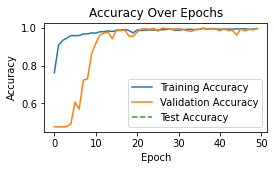

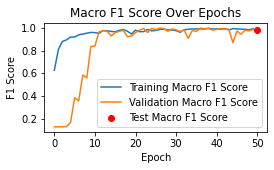

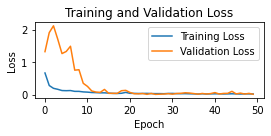

In [42]:
# Evaluate on the test set
test_loss, test_accuracy, test_f1_macro, _, _ = updated_cnn_model.evaluate(test_generator)

# Gather accuracy data
train_accuracy = history_updated_cnn.history['accuracy'][-1]
val_accuracy = history_updated_cnn.history['val_accuracy'][-1]

# Create data dictionary
data = {
    'Accuracy Type': ['Training', 'Validation', 'Testing'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)

# Plot the training, validation, and testing accuracy
plt.figure(figsize=(4, 2))
plt.plot(history_updated_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_updated_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.plot([None]*(epochs-1) + [test_accuracy], label='Test Accuracy', linestyle='--')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot macro F1 score
plt.figure(figsize=(4, 2))
plt.plot(history_updated_cnn.history['f1_score_macro'], label='Training Macro F1 Score')
if 'val_f1_score_macro' in history_updated_cnn.history:
    plt.plot(history_updated_cnn.history['val_f1_score_macro'], label='Validation Macro F1 Score')
plt.scatter(epochs, test_f1_macro, color='red', label='Test Macro F1 Score')
plt.title('Macro F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(4, 2))
plt.plot(history_updated_cnn.history['loss'], label='Training Loss')
plt.plot(history_updated_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


###  Extract and Plot Data

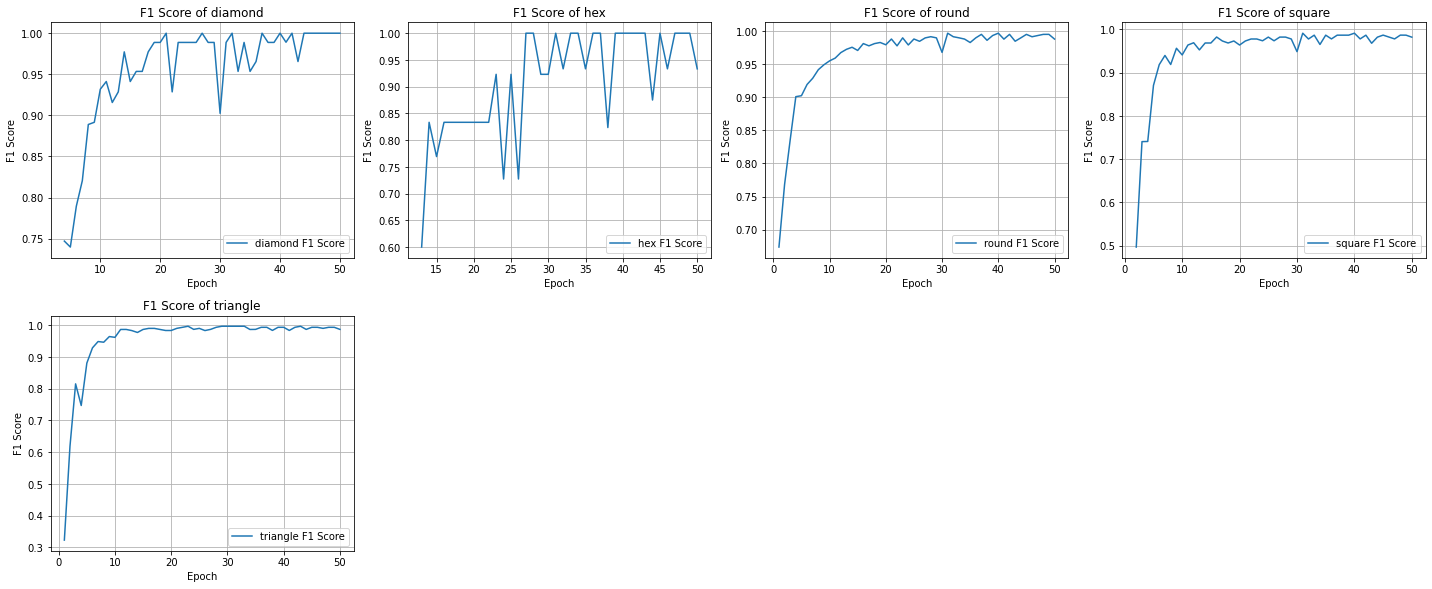

<Figure size 432x288 with 0 Axes>

In [43]:
def plot_per_class_f1_scores(callback, label_names):
    """
    Plot the per-class F1 scores over the epochs in a 4x4 grid, each subplot representing one class.

    Parameters:
    - callback: Instance of PerClassF1Score that has been used during model training.
    - label_names: List of label names corresponding to each class.
    """
    epochs = len(callback.f1_scores_per_class)
    num_classes = len(label_names)
    f1_scores = np.array(callback.f1_scores_per_class)  # Shape will be [epochs, num_classes]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
    axes = axes.flatten()

    for i in range(num_classes):
        ax = axes[i]
        ax.plot(range(1, epochs + 1), f1_scores[:, i], label=f'{label_names[i]} F1 Score')
        ax.set_title(f'F1 Score of {label_names[i]}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower right')
        ax.grid(True)
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

# Example of how to call this function
plot_per_class_f1_scores(per_class_f1_score_callback, label_names)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        45
         hex       1.00      0.86      0.92         7
       round       1.00      1.00      1.00       284
      square       1.00      1.00      1.00       111
    triangle       1.00      1.00      1.00       149

    accuracy                           1.00       596
   macro avg       1.00      0.97      0.98       596
weighted avg       1.00      1.00      1.00       596



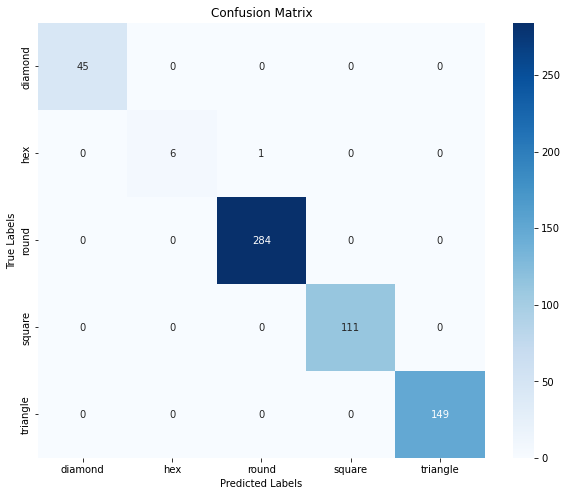

In [39]:
y_pred_val_prob = updated_cnn_model.predict(val_generator)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(val_generator.classes, y_pred_val, target_names=label_names)
print(report)

cm = confusion_matrix(val_generator.classes, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9555 - f1_score_macro: 0.7034 - f1_score_micro: 0.9555 - f1_score_weighted: 0.9605 - loss: 0.1458
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9757 - f1_score_macro: 0.7448 - f1_score_micro: 0.9757 - f1_score_weighted: 0.9796 - loss: 0.0648
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9901 - f1_score_macro: 0.7562 - f1_score_micro: 0.9901 - f1_score_weighted: 0.9913 - loss: 0.0406
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8642 - f1_score_macro: 0.4872 - f1_score_micro: 0.8642 - f1_score_weighted: 0.8660 - loss: 0.1672
                             Model  Training Macro F1 Score  \
0                     Baseline MLP                 0.999354   
1  MLP Model with modified dataset                 0.620120   
2                              CNN                 0.971299   
3                      Updated CNN                 0.991309   

   Validation Macro F1 Score  Testing Macro F1 Score  
0                   0

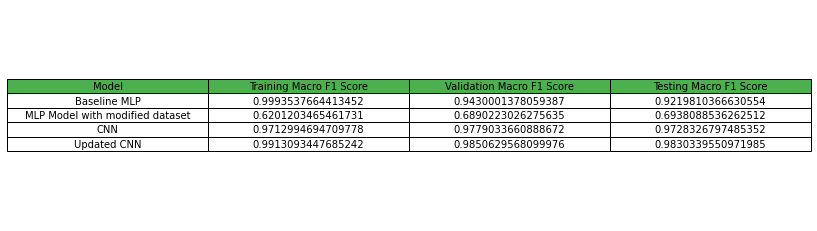

In [44]:
# Plot comparison table
baseline_test_loss, baseline_test_accuracy, baseline_test_f1_macro, _, _ = baseline_categorical.evaluate(test_generator)
baseline_train_f1_macro = history_baseline_categorical.history['f1_score_macro'][-1]
baseline_val_f1_macro = history_baseline_categorical.history['val_f1_score_macro'][-1]

cnn_test_loss, cnn_test_accuracy, cnn_test_f1_macro, _, _ = cnn_model.evaluate(test_generator)
cnn_train_f1_macro = history_cnn.history['f1_score_macro'][-1]
cnn_val_f1_macro = history_cnn.history['val_f1_score_macro'][-1]

updated_cnn_test_loss, updated_cnn_test_accuracy, updated_cnn_test_f1_macro, _, _ = updated_cnn_model.evaluate(test_generator)
updated_cnn_train_f1_macro = history_updated_cnn.history['f1_score_macro'][-1]
updated_cnn_val_f1_macro = history_updated_cnn.history['val_f1_score_macro'][-1]

# Example MLP with modified dataset metrics
mlp_modified_test_loss, mlp_modified_test_accuracy, mlp_modified_test_f1_macro, _, _ = baseline_categorical_new.evaluate(test_generator)
mlp_modified_train_f1_macro = history_baseline_categorical_new.history['f1_score_macro'][-1]
mlp_modified_val_f1_macro = history_baseline_categorical_new.history['val_f1_score_macro'][-1]

# Organize data into a dictionary
data = {
    'Model': ['Baseline MLP', 'MLP Model with modified dataset', 'CNN', 'Updated CNN'],
    'Training Macro F1 Score': [baseline_train_f1_macro, mlp_modified_train_f1_macro, cnn_train_f1_macro, updated_cnn_train_f1_macro],
    'Validation Macro F1 Score': [baseline_val_f1_macro, mlp_modified_val_f1_macro, cnn_val_f1_macro, updated_cnn_val_f1_macro],
    'Testing Macro F1 Score': [baseline_test_f1_macro, mlp_modified_test_f1_macro, cnn_test_f1_macro, updated_cnn_test_f1_macro]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)

# Using pandas Styler for a better looking table
styler = df.style.set_table_styles(
    [{'selector': 'thead th',
      'props': [('background-color', '#4CAF50'), 
                ('color', 'white'), 
                ('font-weight', 'bold'), 
                ('text-align', 'center')]},
     {'selector': 'tbody td',
      'props': [('text-align', 'center')]},
     {'selector': 'tbody tr:nth-child(even)',
      'props': [('background-color', '#f2f2f2')]}]
).set_caption("Model Performance Comparison").set_properties(**{'border': '1px solid black', 'padding': '5px'})

# Display the styled DataFrame
styler

# plot the table using matplotlib
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=['#4CAF50']*4)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.2)

plt.show()


## ResNet Model

In [51]:
import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

# Helper function to create a ResNet block
def resnet_block(inputs, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# Function to build the ResNet model for Keras Tuner
def build_resnet(hp):
    input_shape = (28, 28, 1)
    num_classes = 5  # Update this based on your number of classes

    inputs = layers.Input(shape=input_shape)
    x = resnet_block(inputs, filters=64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Tuning the number of filters in ResNet blocks
    for filter_size in [64, 128, 256]:
        x = resnet_block(x, filters=filter_size)
        x = resnet_block(x, filters=filter_size)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(hp.Int('dense_units', min_value=128, max_value=512, step=32), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    
    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.F1Score(average='macro', name='f1_score_macro'),
            tf.keras.metrics.F1Score(average='micro', name='f1_score_micro'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
        ]
    )
    
    return model

In [53]:
# Set up Keras Tuner
tuner = kt.RandomSearch(
    build_resnet,
    objective='val_accuracy',
    max_trials=10,  # Define the number of trials to run
    executions_per_trial=2,  # How many models to train for each trial
    directory='hyperparam_tuning',  # Directory to store search results
    project_name='traffic_signs_resnet'  # Name of this search project
)

# Start the hyperparameter search
tuner.search(train_generator, epochs=10, validation_data=val_generator)

# Get the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_results = best_model.evaluate(test_generator)
print(f"Test Results: {test_results}")

Reloading Tuner from hyperparam_tuning\traffic_signs_resnet\tuner0.json



C:\Users\HP\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9761 - f1_score_macro: 0.7426 - f1_score_micro: 0.9761 - f1_score_weighted: 0.9794 - loss: 0.0862
Test Results: [0.05493064224720001, 0.9852349162101746, 0.9731580018997192, 0.9852348566055298, 0.985137939453125]


In [57]:
# Defining the history variable during model training
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # or any other number of epochs
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 375ms/step - accuracy: 0.9979 - f1_score_macro: 0.9920 - f1_score_micro: 0.9979 - f1_score_weighted: 0.9979 - loss: 0.0061 - val_accuracy: 0.9966 - val_f1_score_macro: 0.9939 - val_f1_score_micro: 0.9966 - val_f1_score_weighted: 0.9966 - val_loss: 0.0067
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 375ms/step - accuracy: 0.9988 - f1_score_macro: 0.9989 - f1_score_micro: 0.9988 - f1_score_weighted: 0.9988 - loss: 0.0054 - val_accuracy: 0.9966 - val_f1_score_macro: 0.9953 - val_f1_score_micro: 0.9966 - val_f1_score_weighted: 0.9966 - val_loss: 0.0059
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.9990 - f1_score_macro: 0.9942 - f1_score_micro: 0.9990 - f1_score_weighted: 0.9990 - loss: 0.0041 - val_accuracy: 0.9983 - val_f1_score_macro: 0.9971 - val_f1_score_micro: 0.9983 - val_f1_score_weighted: 0.9983 - val_loss: 0.0036
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 469ms/step - accuracy: 0.9974 - f1_score_macro: 0.9930 - f1_score_m

Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - accuracy: 0.9940 - f1_score_macro: 0.9881 - f1_score_micro: 0.9940 - f1_score_weighted: 0.9940 - loss: 0.0144 - val_accuracy: 0.9933 - val_f1_score_macro: 0.9914 - val_f1_score_micro: 0.9933 - val_f1_score_weighted: 0.9933 - val_loss: 0.0195
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.9979 - f1_score_macro: 0.9893 - f1_score_micro: 0.9979 - f1_score_weighted: 0.9979 - loss: 0.0082 - val_accuracy: 0.9950 - val_f1_score_macro: 0.9929 - val_f1_score_micro: 0.9950 - val_f1_score_weighted: 0.9949 - val_loss: 0.0133
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.9965 - f1_score_macro: 0.9863 - f1_score_micro: 0.9965 - f1_score_weighted: 0.9965 - loss: 0.0072 - val_accuracy: 0.9933 - val_f1_score_macro: 0.9894 - val_f1_score_micro: 0.9933 - val_f1_score_weighted: 0.9932 - val_loss: 0.0199
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.9997 - f1_score_macro: 0.9767 - f1_sco

KeyboardInterrupt: 

Test Accuracy: 98.52%
Test Macro F1 Score: 0.9732
  Metric Type  Training  Validation   Testing
0    Accuracy  0.996607    0.988255  0.985235
1    F1 Macro  0.997485    0.973478  0.973158


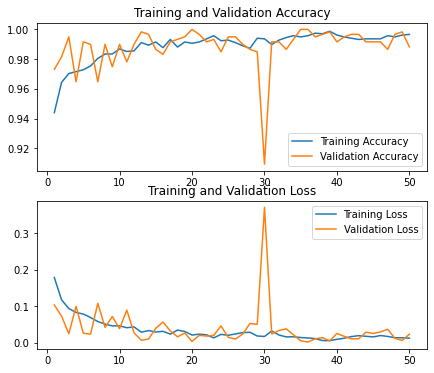

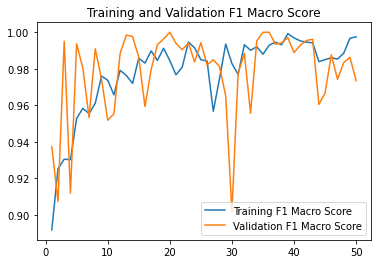

In [56]:
# Extract the test metrics
test_loss = test_results[0]
test_accuracy = test_results[1]
test_f1_macro = test_results[2]  # Adjust index based on printed results

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Macro F1 Score: {test_f1_macro:.4f}")

# Create a DataFrame for accuracies and macro F1 score
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
train_f1_macro = history.history['f1_score_macro'][-1]
val_f1_macro = history.history['val_f1_score_macro'][-1]

data = {
    'Metric Type': ['Accuracy', 'F1 Macro'],
    'Training': [train_accuracy, train_f1_macro],
    'Validation': [val_accuracy, val_f1_macro],
    'Testing': [test_accuracy, test_f1_macro]
}

df = pd.DataFrame(data)
print(df)

# Function to plot training history
def plot_training_history(history):
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(7,6))

    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

# Function to plot F1 macro score history
def plot_f1_macro_history(history):
    epochs_range = range(1, len(history.history['f1_score_macro']) + 1)
    plt.figure(figsize=(6, 4))

    plt.plot(epochs_range, history.history['f1_score_macro'], label='Training F1 Macro Score')
    plt.plot(epochs_range, history.history['val_f1_score_macro'], label='Validation F1 Macro Score')
    plt.legend(loc='lower right')
    plt.title('Training and Validation F1 Macro Score')

    plt.show()

plot_f1_macro_history(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9555 - f1_score_macro: 0.7034 - f1_score_micro: 0.9555 - f1_score_weighted: 0.9605 - loss: 0.1458
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9757 - f1_score_macro: 0.7448 - f1_score_micro: 0.9757 - f1_score_weighted: 0.9796 - loss: 0.0648
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9901 - f1_score_macro: 0.7562 - f1_score_micro: 0.9901 - f1_score_weighted: 0.9913 - loss: 0.0406
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8642 - f1_score_macro: 0.4872 - f1_score_micro: 0.8642 - f1_score_weighted: 0.8660 - loss: 0.1672
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9913 - f1_score_macro: 0.7493 - f1_score_micro: 0.9913 - f1_score_weighted: 0.9921 - loss: 0.0151
                             Model  Training Macro F1 Score  \
0                     Baseline MLP                 0.999354   
1  MLP Model with modified dataset                 0.620120   
2                              CNN                 

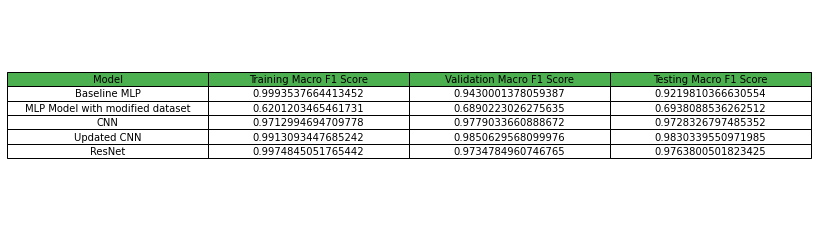

In [58]:
baseline_test_loss, baseline_test_accuracy, baseline_test_f1_macro, _, _ = baseline_categorical.evaluate(test_generator)
baseline_train_f1_macro = history_baseline_categorical.history['f1_score_macro'][-1]
baseline_val_f1_macro = history_baseline_categorical.history['val_f1_score_macro'][-1]

cnn_test_loss, cnn_test_accuracy, cnn_test_f1_macro, _, _ = cnn_model.evaluate(test_generator)
cnn_train_f1_macro = history_cnn.history['f1_score_macro'][-1]
cnn_val_f1_macro = history_cnn.history['val_f1_score_macro'][-1]

updated_cnn_test_loss, updated_cnn_test_accuracy, updated_cnn_test_f1_macro, _, _ = updated_cnn_model.evaluate(test_generator)
updated_cnn_train_f1_macro = history_updated_cnn.history['f1_score_macro'][-1]
updated_cnn_val_f1_macro = history_updated_cnn.history['val_f1_score_macro'][-1]

mlp_modified_test_loss, mlp_modified_test_accuracy, mlp_modified_test_f1_macro, _, _ = baseline_categorical_new.evaluate(test_generator)
mlp_modified_train_f1_macro = history_baseline_categorical_new.history['f1_score_macro'][-1]
mlp_modified_val_f1_macro = history_baseline_categorical_new.history['val_f1_score_macro'][-1]

# Evaluate ResNet model
resnet_test_results = best_model.evaluate(test_generator)
resnet_test_loss = resnet_test_results[0]
resnet_test_accuracy = resnet_test_results[1]
resnet_test_f1_macro = resnet_test_results[2]  # Adjust index based on printed results

resnet_train_f1_macro = history.history['f1_score_macro'][-1]
resnet_val_f1_macro = history.history['val_f1_score_macro'][-1]

# Organize data into a dictionary
data = {
    'Model': ['Baseline MLP', 'MLP Model with modified dataset', 'CNN', 'Updated CNN', 'ResNet'],
    'Training Macro F1 Score': [baseline_train_f1_macro, mlp_modified_train_f1_macro, cnn_train_f1_macro, updated_cnn_train_f1_macro, resnet_train_f1_macro],
    'Validation Macro F1 Score': [baseline_val_f1_macro, mlp_modified_val_f1_macro, cnn_val_f1_macro, updated_cnn_val_f1_macro, resnet_val_f1_macro],
    'Testing Macro F1 Score': [baseline_test_f1_macro, mlp_modified_test_f1_macro, cnn_test_f1_macro, updated_cnn_test_f1_macro, resnet_test_f1_macro]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)

# Using pandas Styler for a better looking table
styler = df.style.set_table_styles(
    [{'selector': 'thead th',
      'props': [('background-color', '#4CAF50'), 
                ('color', 'white'), 
                ('font-weight', 'bold'), 
                ('text-align', 'center')]},
     {'selector': 'tbody td',
      'props': [('text-align', 'center')]},
     {'selector': 'tbody tr:nth-child(even)',
      'props': [('background-color', '#f2f2f2')]}]
).set_caption("Model Performance Comparison").set_properties(**{'border': '1px solid black', 'padding': '5px'})

# Display the styled DataFrame
styler

# Alternatively, plot the table using matplotlib with improved styling
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=['#4CAF50']*4)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.2)

plt.show()


## Independant Dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Root directory for independent dataset
independent_dataset_dir = 'trafficsign_test'
data = {'image_path': [], 'label': []}

# Define the label mapping
label_mapping = {
    'hex': [14],
    'triangle': list(range(11, 14)) + list(range(18, 32)),
    'round': list(range(0, 11)) + [15, 16, 17] + list(range(32, 43)),
    'square': [],  # No explicit square mapping provided
    'diamond': [12]
}

# Inverse the label_mapping for easier lookup
inverse_label_mapping = {}
for shape, ids in label_mapping.items():
    for id in ids:
        inverse_label_mapping[id] = shape

# Load the images and their labels
def load_images(root_dir):
    for label_dir in os.listdir(root_dir):
        label_dir_path = os.path.join(root_dir, label_dir)
        if os.path.isdir(label_dir_path):
            for image_filename in os.listdir(label_dir_path):
                if image_filename == '.DS_Store':
                    continue
                image_path = os.path.join(label_dir_path, image_filename)
                data['image_path'].append(image_path)
                
                # Use the directory name as the label and map it
                label = int(label_dir)
                shape_label = inverse_label_mapping.get(label, 'unknown')
                data['label'].append(shape_label)

load_images(independent_dataset_dir)
test_df = pd.DataFrame(data)

# Remove all rows with the label "unknown"
test_df = test_df[test_df['label'] != 'unknown']

# Print DataFrame content to check its structure
print(test_df.head())

# Preprocess images
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(28, 28), color_mode='grayscale')
    image = img_to_array(image)
    image /= 255.0  # Normalize
    return image

# Convert images to array
test_images = np.array([preprocess_image(path) for path in test_df['image_path']])

# Verify the number of images and labels match
print(f"Number of images: {len(test_images)}")
print(f"Number of labels: {len(test_df)}")

# Load model
#updated_cnn_model = tf.keras.models.load_model('updated_cnn_model.h5')

# Encode true labels using LabelEncoder
label_encoder = LabelEncoder()
all_labels = ['hex', 'triangle', 'round', 'square', 'diamond']
label_encoder.fit(all_labels)

# Transform labels in test_df
test_df['label'] = label_encoder.transform(test_df['label'])
encoded_labels = test_df['label']
test_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=len(label_encoder.classes_))

# Run the model on the test images
predictions = updated_cnn_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Print unique predicted classes to debug
print("Unique predicted classes:", np.unique(predicted_classes))

# Ensure predicted labels are numerical
predicted_labels = predicted_classes

# Add numerical predicted labels to test_df
test_df['predicted_label'] = predicted_labels

# Ensure test_labels is populated correctly
print("Shape of test_labels:", test_labels.shape)

# Evaluate model
eval_results = updated_cnn_model.evaluate(test_images, test_labels)

# Print evaluation results
test_loss, test_acc, test_f1_macro, _, _ = eval_results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Macro F1 Score: {test_f1_macro:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Classification Report
report = classification_report(test_df['label'], test_df['predicted_label'], target_names=label_encoder.classes_)
print(report)


                                 image_path  label
0  trafficsign_test\0\00000_00000_00000.png  round
1  trafficsign_test\0\00000_00000_00001.png  round
2  trafficsign_test\0\00000_00000_00002.png  round
3  trafficsign_test\0\00000_00000_00003.png  round
4  trafficsign_test\0\00000_00000_00004.png  round
Number of images: 39209
Number of labels: 39209
 648/1226 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step